### Import Library

Reference

* https://github.com/cure-lab/LTSF-Linear
* https://today-1.tistory.com/60

In [180]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from tqdm import tqdm
from argparse import Namespace
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

### Data Directory

In [181]:
feature_path = "../../data/merge_data_V6_eng_V1.csv"
region_feature_path = "../../data/nationwide_eng_V1.csv"

### Load Data

In [193]:
interest_rate = ["call_interest_rate", "government_bond_3yr", "deposit_bank_loan_rate_avg"]
stock = ["KOSPI_index", "KOSDAQ_index", "NASDAQ_index"]
money_supply = ["M2_Korea", "M2_USA"]
liquidity = ["broad_liquidity"]
inflation = ["CPI_growth_rate"]
exchange_rate = ["USD_KRW_exchange_rate"]
gdp = ["real_GDP_growth_rate"]
construction = ["residential_building_start_status", "residential_building_permit_status"]
construction_production = ["construction_production_index_seasonally_adjusted"]

column = interest_rate + stock + money_supply + liquidity \
    + inflation + exchange_rate + gdp + \
    construction + construction_production

nf = pd.read_csv(region_feature_path)[:17].T.dropna()
nf.columns = nf.iloc[0]
nf = nf.iloc[1:].astype(float)

df = pd.read_csv(feature_path).T
df.columns = df.iloc[0]
df = df.iloc[1:]

df = df[column]
df = pd.concat([df,nf], axis = 1)
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna()

date = 'Date'
df = df.reset_index(names=date) 
df[date] = pd.to_datetime(df[date]) 

df.reset_index(drop=True, inplace=True)
df.index.name = "num"

In [194]:
df.columns

Index(['Date', 'call_interest_rate', 'government_bond_3yr',
       'deposit_bank_loan_rate_avg', 'KOSPI_index', 'KOSDAQ_index',
       'NASDAQ_index', 'M2_Korea', 'M2_USA', 'broad_liquidity',
       'CPI_growth_rate', 'USD_KRW_exchange_rate', 'real_GDP_growth_rate',
       'residential_building_start_status',
       'residential_building_permit_status',
       'construction_production_index_seasonally_adjusted',
       'Seoul_apartment_sale_price_index', 'Busan_apartment_sale_price_index',
       'Daegu_apartment_sale_price_index',
       'Incheon_apartment_sale_price_index',
       'Gwangju_apartment_sale_price_index',
       'Daejeon_apartment_sale_price_index',
       'Ulsan_apartment_sale_price_index', 'Sejong_apartment_sale_price_index',
       'Gyeonggi_apartment_sale_price_index',
       'Gangwon_apartment_sale_price_index',
       'Chungbuk_apartment_sale_price_index',
       'Chungnam_apartment_sale_price_index',
       'Jeonbuk_apartment_sale_price_index',
       'Jeonnam_apa

In [195]:
target_column = [
    "Seoul",
    "Busan",
    "Daegu",
    "Incheon",
    "Gwangju",
    "Daejeon",
    "Ulsan",
    "Sejong",
    "Gyeonggi",
    "Gangwon",
    "Chungbuk",
    "Chungnam",
    "Jeonbuk",
    "Jeonnam",
    "Gyeongbuk",
    "Gyeongnam",
    "Jeju",
]

In [200]:
train_df

Date       Date  call_interest_rate  government_bond_3yr  \
num                                                        
0    2006-01-15                3.74                 5.02   
1    2006-02-15                3.92                 4.87   
2    2006-03-15                3.97                 4.93   
3    2006-04-15                3.97                 4.95   
4    2006-05-15                3.96                 4.78   
..          ...                 ...                  ...   
172  2020-05-15                0.70                 0.88   
173  2020-06-15                0.48                 0.85   
174  2020-07-15                0.48                 0.83   
175  2020-08-15                0.50                 0.83   
176  2020-09-15                0.48                 0.91   

Date  deposit_bank_loan_rate_avg  KOSPI_index  KOSDAQ_index  NASDAQ_index  \
num                                                                         
0                           5.79  1379.323810    708.266190   2289.991504   
1                           5.76  1341.722000    656.840500   2273.666311   
2                           5.89  1331.720000    657.500000   2300.255668   
3                           5.83  1415.921000    693.712500   2338.677362   
4                           5.89  1388.834500    663.351000   2245.281816   
..                           ...          ...           ...           ...   
172                         2.82  1965.174211    695.297368   9105.655469   
173                         2.72  2134.696818    743.568182   9839.971325   
174                         2.70  2195.948696    781.016522  10499.862704   
175                         2.63  2349.873000    835.289500  11212.290504   
176                         2.66  2371.516190    865.527619  11088.679967   

Date   M2_Korea   M2_USA  broad_liquidity  ...  \
num                                        ...   
0     1027.2356   6730.3              8.7  ...   
1     1034.3588   6754.9              8.1  ...   
2     1038.7277   6769.5              8.5  ...   
3     1046.4002   6807.0              7.9  ...   
4     1056.9430   6813.9              8.8  ...   
..          ...      ...              ...  ...   
172   3048.9437  17868.4              8.6  ...   
173   3074.1968  18161.5              8.0  ...   
174   3089.4542  18311.4              8.4  ...   
175   3098.8595  18382.2              7.6  ...   
176   3116.0918  18606.8              8.3  ...   

Date  Sejong_apartment_sale_price_index  Gyeonggi_apartment_sale_price_index  \
num                                                                            
0                                  75.7                                 66.3   
1                                  77.0                                 67.2   
2                                  82.0                                 68.0   
3                                  77.4                                 68.9   
4                                  78.0                                 69.8   
..                                  ...                                  ...   
172                               114.2                                109.8   
173                               119.6                                112.2   
174                               131.1                                115.5   
175                               146.8                                117.0   
176                               151.9                                118.0   

Date  Gangwon_apartment_sale_price_index  Chungbuk_apartment_sale_price_index  \
num                                                                             
0                                   58.1                                 64.0   
1                                   58.4                                 65.2   
2                                   57.6                                 65.6   
3                                   58.2                                 66.5   
4                                   59.

In [197]:
train_df.columns

Index(['Date', 'call_interest_rate', 'government_bond_3yr',
       'deposit_bank_loan_rate_avg', 'KOSPI_index', 'KOSDAQ_index',
       'NASDAQ_index', 'M2_Korea', 'M2_USA', 'broad_liquidity',
       'CPI_growth_rate', 'USD_KRW_exchange_rate', 'real_GDP_growth_rate',
       'residential_building_start_status',
       'residential_building_permit_status',
       'construction_production_index_seasonally_adjusted',
       'Seoul_apartment_sale_price_index', 'Busan_apartment_sale_price_index',
       'Daegu_apartment_sale_price_index',
       'Incheon_apartment_sale_price_index',
       'Gwangju_apartment_sale_price_index',
       'Daejeon_apartment_sale_price_index',
       'Ulsan_apartment_sale_price_index', 'Sejong_apartment_sale_price_index',
       'Gyeonggi_apartment_sale_price_index',
       'Gangwon_apartment_sale_price_index',
       'Chungbuk_apartment_sale_price_index',
       'Chungnam_apartment_sale_price_index',
       'Jeonbuk_apartment_sale_price_index',
       'Jeonnam_apa

In [198]:
from scipy.stats import ks_2samp

# Feature와 Target 간 KS 테스트
for feature in train_df.columns[1:]:
    statistic, p_value = ks_2samp(train_df[nf.columns[0]], train_df[feature])
    print(f"Feature: {feature}, KS Statistic: {statistic:.4f}, p-value: {p_value:.4f}")


Feature: call_interest_rate, KS Statistic: 1.0000, p-value: 0.0000
Feature: government_bond_3yr, KS Statistic: 1.0000, p-value: 0.0000
Feature: deposit_bank_loan_rate_avg, KS Statistic: 1.0000, p-value: 0.0000
Feature: KOSPI_index, KS Statistic: 1.0000, p-value: 0.0000
Feature: KOSDAQ_index, KS Statistic: 1.0000, p-value: 0.0000
Feature: NASDAQ_index, KS Statistic: 1.0000, p-value: 0.0000
Feature: M2_Korea, KS Statistic: 1.0000, p-value: 0.0000
Feature: M2_USA, KS Statistic: 1.0000, p-value: 0.0000
Feature: broad_liquidity, KS Statistic: 1.0000, p-value: 0.0000
Feature: CPI_growth_rate, KS Statistic: 1.0000, p-value: 0.0000
Feature: USD_KRW_exchange_rate, KS Statistic: 1.0000, p-value: 0.0000
Feature: real_GDP_growth_rate, KS Statistic: 1.0000, p-value: 0.0000
Feature: residential_building_start_status, KS Statistic: 1.0000, p-value: 0.0000
Feature: residential_building_permit_status, KS Statistic: 1.0000, p-value: 0.0000
Feature: construction_production_index_seasonally_adjusted, KS S

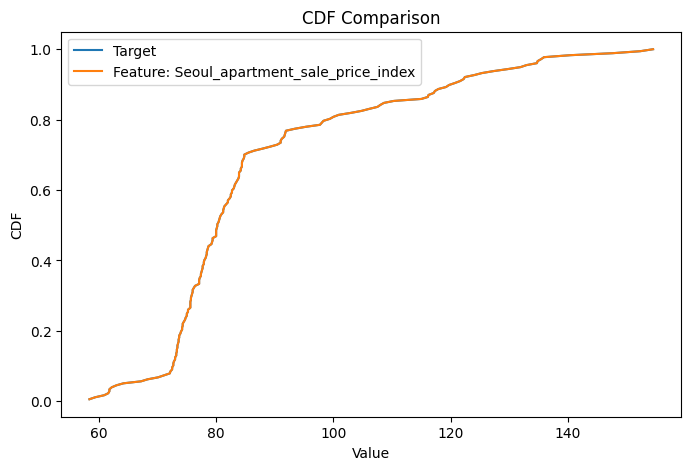

In [199]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import cumfreq

# Target과 Feature의 CDF 비교
def plot_cdf(data, label):
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    plt.plot(sorted_data, cdf, label=label)

plt.figure(figsize=(8, 5))

# Target의 CDF
plot_cdf(train_df[nf.columns[0]], label='Target')

# Feature들의 CDF
for feature in columns_to_use:
    plot_cdf(train_df[feature], label=f'Feature: {feature}')

plt.xlabel('Value')
plt.ylabel('CDF')
plt.legend()
plt.title('CDF Comparison')
plt.show()


### DLinear 

In [227]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x

class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

class DLinear(nn.Module):
    """
    Decomposition-Linear
    """
    def __init__(self, configs):
        super(DLinear, self).__init__()
        self.seq_len = configs.seq_len # window_size
        self.pred_len = configs.pred_len # forcast_size

        # Decompsition Kernel Size
        kernel_size = configs.ker_len
        self.decompsition = series_decomp(kernel_size) # kernel_size
        self.individual = configs.individual # False
        self.channels = configs.enc_in # feature_size

        if self.individual:
            self.Linear_Seasonal = nn.ModuleList()
            self.Linear_Trend = nn.ModuleList()
            
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))

                # Use this two lines if you want to visualize the weights
                self.Linear_Seasonal[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
                self.Linear_Trend[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
        else:
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
            
            # Use this two lines if you want to visualize the weights
            self.Linear_Seasonal.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
            self.Linear_Trend.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        seasonal_init, trend_init = self.decompsition(x)
        seasonal_init, trend_init = seasonal_init.permute(0,2,1), trend_init.permute(0,2,1)
        if self.individual:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],dtype=seasonal_init.dtype).to(seasonal_init.device)
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),self.pred_len],dtype=trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)
            trend_output = self.Linear_Trend(trend_init)

        x = seasonal_output + trend_output
        return x.permute(0,2,1) # to [Batch, Output length, Channel]

### Tools for Prediction

In [ ]:
def standardization(train_df, test_df, not_col, target): 
    train_df_ = train_df.copy()
    test_df_ = test_df.copy()
    col =  [col for col in list(train_df.columns) if col not in [not_col]]
    mean_dict = {}
    std_dict = {}
    
    for x in col:
        mean, std = train_df_.agg(["mean", "std"]).loc[:,x]
        train_df_.loc[:, x] = (train_df_[x] - mean) / std
        test_df_.loc[:, x] = (test_df_[x] - mean) / std
        if x in target:
            mean_dict[x] = mean
            std_dict[x] = std
    return train_df_, test_df_, mean_dict, std_dict

def time_slide_df(df, window_size, forecast_size, date, target):
    df_ = df.copy()
    data_list = []
    dap_list = []
    date_list = []
    for idx in range(0, df_.shape[0] - window_size - forecast_size + 1):
        # x: features from the past window_size (including columns)
        x = df_.loc[idx:idx+window_size-1, target].values 
        # get target value for future forecast size 
        y = df_.loc[idx+window_size:idx+window_size+forecast_size-1, target].values
        # get date value for future forecast size 
        date_ = df_.loc[idx+window_size:idx+window_size+forecast_size-1, date].values
        
        data_list.append(x)
        dap_list.append(y)
        date_list.append(date_)
    return np.array(data_list, dtype='float32'), np.array(dap_list, dtype='float32'), np.array(date_list)

class Data(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

### Common Experiment Setting

In [337]:
window_size = 3
forecast_size= 3 

train_df = df[0:177]
test_df = df[177-forecast_size:]
test_df.reset_index(drop=True, inplace=True)
test_df.index.name = "num"

### Train and Save model (Input V1: Variables used in MLP of FA-SEM)
* input: "call_interest_rate", "real_GDP_growth_rate", "residential_building_start_status", f"{target}"
* window_size = 3
* forecast_size= 3 

In [353]:
### Experiment Setting
version = "V1"
batch_size = 16
kernel_size = 25
epoch_ = 500
lr = 0.001
patience = 20  # easrly stopping

columns_to_use = ["call_interest_rate", "real_GDP_growth_rate", "residential_building_start_status"] \
                    + nf.columns.tolist()
configs = Namespace( # Convert configs dictionary to Namespace
    seq_len=max(window_size, 1),  # Set minimum input length to 1
    pred_len=forecast_size,
    ker_len=kernel_size,  # 25
    individual=False, 
    enc_in= len(columns_to_use) # feature_size
)

In [354]:
# Prepare Dataset
# 정규화된 train_df, test_df와 각 칼럼에 대한 mean_, std_ 딕셔너리가 출력됨. 
train_df_fe, test_df_fe, mean_, std_ = standardization(train_df, test_df, date, columns_to_use)
    
train_x, train_y, train_date = time_slide_df(train_df_fe, window_size, forecast_size, date, columns_to_use)
test_x, test_y, test_date = time_slide_df(test_df_fe, window_size, forecast_size, date, columns_to_use)
    
# Prepare DataLoader 
train_ds = Data(train_x, train_y)
test_ds = Data(test_x, test_y)
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size = len(test_df), shuffle=False)

# Train the model 
train_loss_list = [] # save the train loss
test_loss_list = [] # save the test loss

# Define the model
DLinear_model = DLinear(configs=configs)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(DLinear_model.parameters(), lr=lr)
max_loss = 999999999

patience_counter = 0

 43%|████▎     | 213/500 [00:06<00:08, 34.76it/s]


Early stopping triggered.


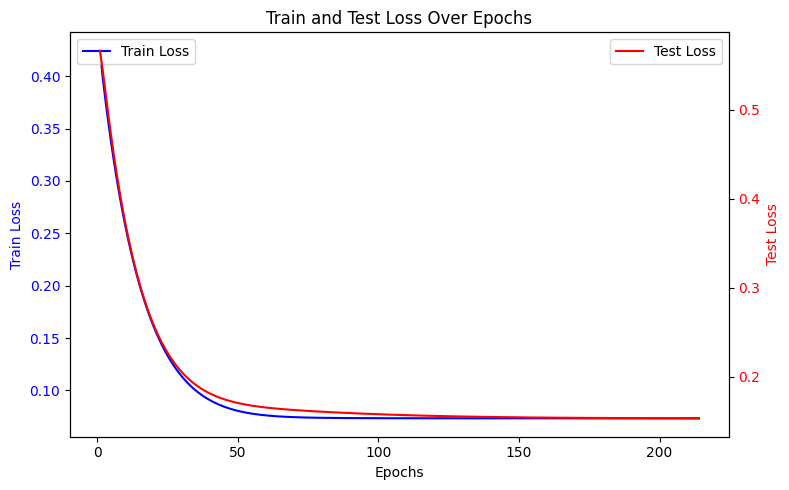

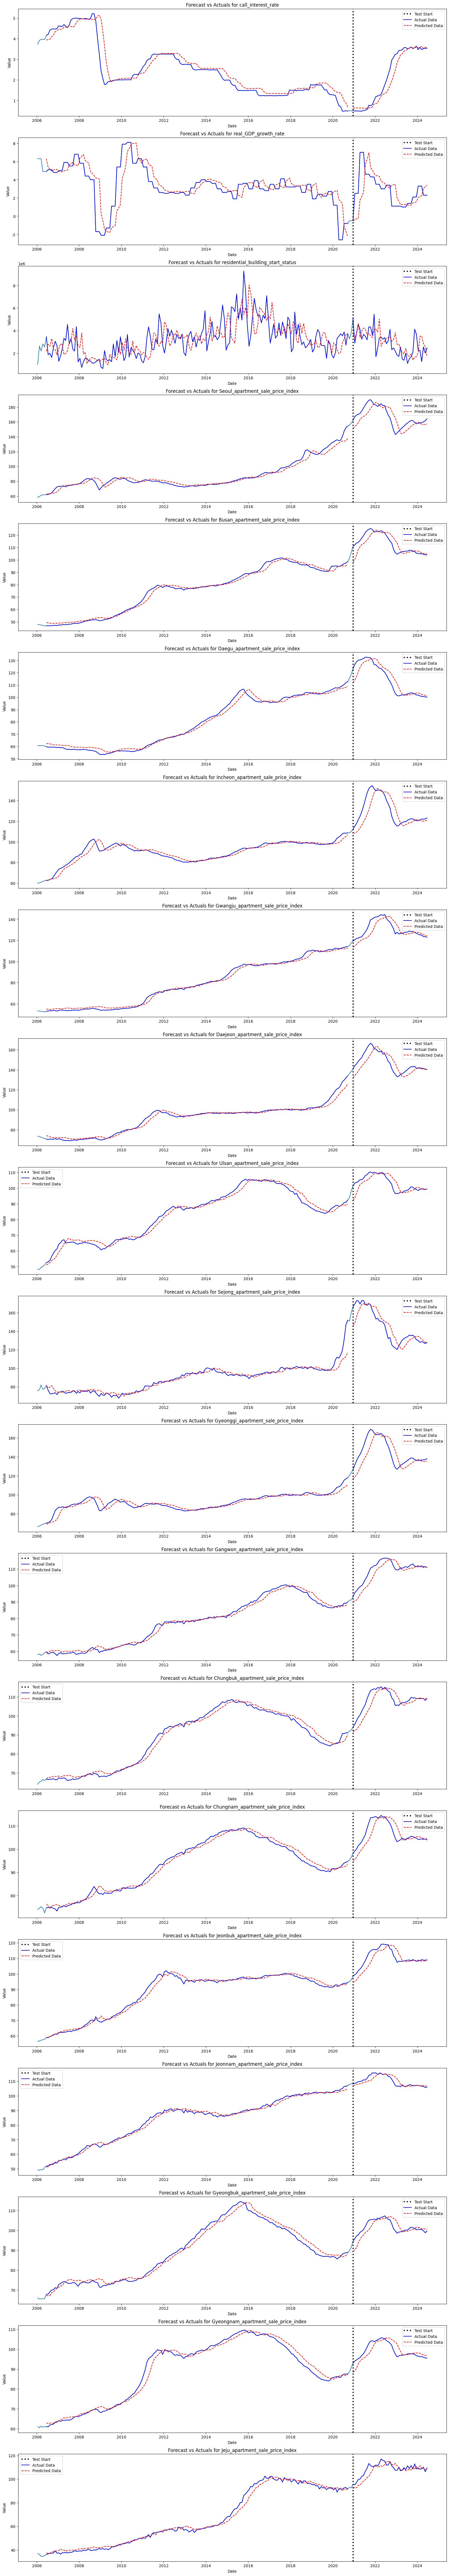

In [342]:
for epoch in tqdm(range(1, epoch_+1)):
    loss_list = []
    DLinear_model.train()
    train_loss = 0.0 
    for batch_idx, (data, target) in enumerate(train_dl):
        
        optimizer.zero_grad()
        output = DLinear_model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        
    train_loss = np.mean(loss_list) 
    train_loss_list.append(train_loss) 

    DLinear_model.eval()
    with torch.no_grad():
        test_loss_list_epoch = []
        for data, target in test_dl:
            output = DLinear_model(data)
            test_loss = criterion(output, target)
            test_loss_list_epoch.append(test_loss.item())
            
        test_loss = np.mean(test_loss_list_epoch)
        test_loss_list.append(test_loss)

    if train_loss < max_loss:
        torch.save(DLinear_model.state_dict(), f"./DLinear{version}.pth")
        max_loss = train_loss
        # print("Train_loss={:.3f}, Test_loss={:.3f}, Model Saved".format(train_loss, test_loss))
        dlinear_best_epoch = epoch
        dlinear_best_train_loss = train_loss
        dlinear_best_test_loss = test_loss
    else:
        patience_counter += 1
        # print("Train_loss={:.3f}, Test_loss={:.3f}, Patience: {}/{}".format(train_loss, test_loss, patience_counter, patience))
    
    if patience_counter >= patience:
        print("Early stopping triggered.")
        break
    
fig, ax1 = plt.subplots(figsize=(8, 5))
epochs = range(1, len(train_loss_list) + 1)
ax1.plot(epochs, train_loss_list, label='Train Loss', color='b')
ax1.set_xlabel('Epochs')
ax1.set_ylabel("Train Loss",color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.legend(loc="upper left")
# ax1.grid()
ax2 = ax1.twinx()
ax2.plot(epochs, test_loss_list, label='Test Loss',color='r')
ax2.set_xlabel('Epochs')
ax2.set_ylabel("Test Loss",color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.legend(loc="upper right") 
# ax2.grid()
plt.title('Train and Test Loss Over Epochs')
fig.tight_layout()
plt.show()
    
# Load model and Evaluate
DLinear_model.load_state_dict(torch.load(f"./DLinear{version}.pth"))  # 최적 모델 로드
DLinear_model.eval()

train_dl  = DataLoader(train_ds,  batch_size = len(train_df), shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size = len(test_df), shuffle=False)
with torch.no_grad():
    for data, target in train_dl:
        train_output = DLinear_model(data)
        train_predicted = train_output[:, -1, :].cpu().numpy()  # Last timestep predictions
        train_actual = target[:, -1, :].cpu().numpy()     # Last timestep actual values
        train_dates = train_date[:, -1]                    # Dates corresponding to the last forecast
    
    for data, target in test_dl:
        test_output = DLinear_model(data)
        test_predicted = test_output[:, -1, :].cpu().numpy()  # Last timestep predictions
        test_actual = target[:, -1, :].cpu().numpy()     # Last timestep actual values
        test_dates = test_date[:, -1]  
    
plt.figure(figsize=(20, len(columns_to_use) * 6))  # Adjust the figure size as needed
for i in range(len(columns_to_use)):
    idv_mean = mean_[columns_to_use[i]]
    idv_std = std_[columns_to_use[i]]
    plt.subplot(len(columns_to_use), 1, i + 1)
    plt.plot(df['Date'], df[columns_to_use[i]])
    plt.plot(train_dates, train_actual[:, i]*idv_std+idv_mean, c="b")
    plt.plot(train_dates, train_predicted[:, i]*idv_std+idv_mean, linestyle='--', c="r")
    plt.axvline(x=test_dates[0], color='black', linestyle=':', linewidth=3,label="Test Start")
    plt.plot(test_dates, test_actual[:, i]*idv_std+idv_mean, label='Actual Data', c="b")
    plt.plot(test_dates, test_predicted[:, i]*idv_std+idv_mean, label='Predicted Data', linestyle='--', c="r")
    plt.title(f'Forecast vs Actuals for {columns_to_use[i]}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()        
    

In [355]:
# Load model and Evaluate
DLinear_model.load_state_dict(torch.load(f"./DLinear{version}.pth"))  # 최적 모델 로드
DLinear_model.eval()

with torch.no_grad():
    for data, target in test_dl:
        test_output = DLinear_model(data)
        test_predicted = test_output[:, -1, :].cpu().numpy()  # Last timestep predictions
        test_actual = target[:, -1, :].cpu().numpy()     # Last timestep actual values
        test_dates = test_date[:, -1]  
    
plt.figure(figsize=(20, len(columns_to_use) * 6))  # Adjust the figure size as needed
for i in range(len(columns_to_use)):
    real = test_actual[:, i]*idv_std+idv_mean
    pred = test_predicted[:, i]*idv_std+idv_mean
    rmse = mean_squared_error(real, pred)**0.5
    r2 = r2_score(real, pred)
    if columns_to_use[i] in nf.columns:
        val = [columns_to_use[i].split("_")[0], rmse, r2]
        pd.DataFrame(val).T.to_csv(f"./result{version}.csv", mode='a', header=False, index=False)
    

<Figure size 2000x12000 with 0 Axes>

### Train and Save model (Input V2: All variables used in FA-SEM-MLP)
* input: "call_interest_rate", "government_bond_3yr", "deposit_bank_loan_rate_avg", "KOSPI_index", "KOSDAQ_index", "NASDAQ_index", "M2_Korea", "M2_USA", "broad_liquidity", "CPI_growth_rate", "USD_KRW_exchange_rate", "real_GDP_growth_rate", "residential_building_start_status", "residential_building_permit_status", "construction_production_index_seasonally_adjusted", 
f"{target}"
* window_size = 3
* forecast_size= 3 

In [356]:
### Experiment Setting
version = "V2"
### Experiment Setting
batch_size = 16
kernel_size = 25
epoch_ = 500
lr = 0.001
patience = 20  # easrly stopping

columns_to_use = column + nf.columns.tolist()
configs = Namespace( # Convert configs dictionary to Namespace
    seq_len=max(window_size, 1),  # Set minimum input length to 1
    pred_len=forecast_size,
    ker_len=kernel_size,  # 25
    individual=False, 
    enc_in= len(columns_to_use) # feature_size
)

In [357]:
# Prepare Dataset
# 정규화된 train_df, test_df와 각 칼럼에 대한 mean_, std_ 딕셔너리가 출력됨. 
train_df_fe, test_df_fe, mean_, std_ = standardization(train_df, test_df, date, columns_to_use)
    
train_x, train_y, train_date = time_slide_df(train_df_fe, window_size, forecast_size, date, columns_to_use)
test_x, test_y, test_date = time_slide_df(test_df_fe, window_size, forecast_size, date, columns_to_use)
    
# Prepare DataLoader 
train_ds = Data(train_x, train_y)
test_ds = Data(test_x, test_y)
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size = len(test_df), shuffle=False)

# Train the model 
train_loss_list = [] # save the train loss
test_loss_list = [] # save the test loss

# Define the model
DLinear_model = DLinear(configs=configs)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(DLinear_model.parameters(), lr=lr)
max_loss = 999999999

patience_counter = 0

 28%|██▊       | 138/500 [00:04<00:11, 32.56it/s]


Early stopping triggered.


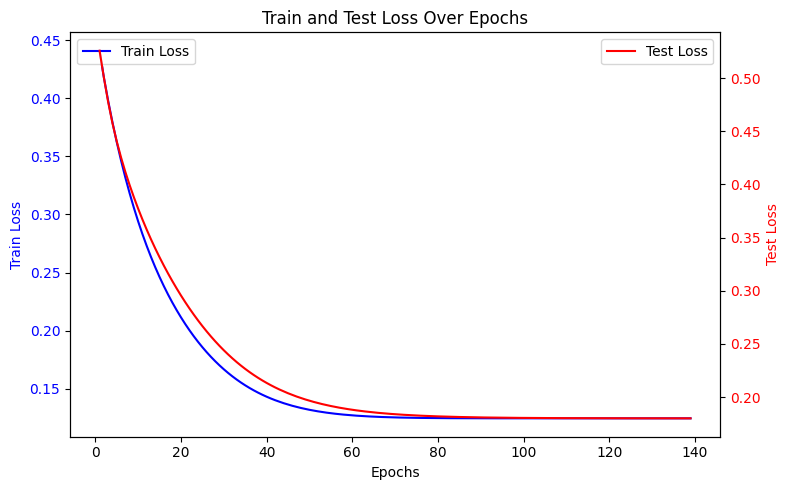

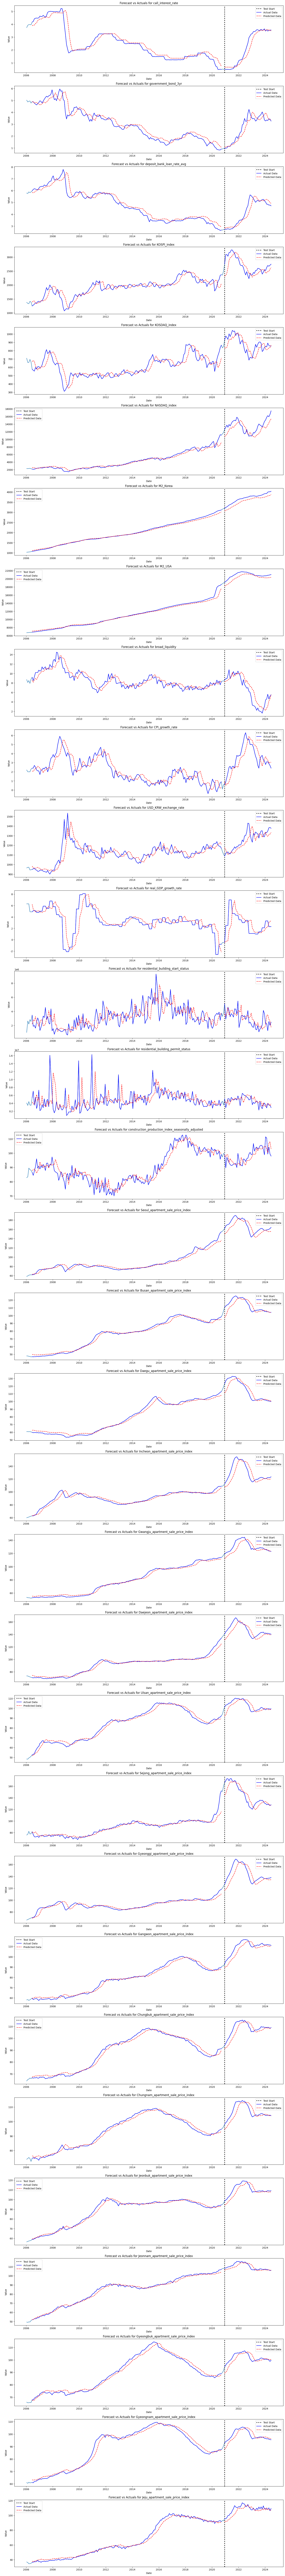

In [344]:

    
for epoch in tqdm(range(1, epoch_+1)):
    loss_list = []
    DLinear_model.train()
    train_loss = 0.0 
    for batch_idx, (data, target) in enumerate(train_dl):
        
        optimizer.zero_grad()
        output = DLinear_model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        
    train_loss = np.mean(loss_list) 
    train_loss_list.append(train_loss) 

    DLinear_model.eval()
    with torch.no_grad():
        test_loss_list_epoch = []
        for data, target in test_dl:
            output = DLinear_model(data)
            test_loss = criterion(output, target)
            test_loss_list_epoch.append(test_loss.item())
            
        test_loss = np.mean(test_loss_list_epoch)
        test_loss_list.append(test_loss)

    if train_loss < max_loss:
        torch.save(DLinear_model.state_dict(), f"./DLinear{version}.pth")
        max_loss = train_loss
        # print("Train_loss={:.3f}, Test_loss={:.3f}, Model Saved".format(train_loss, test_loss))
        dlinear_best_epoch = epoch
        dlinear_best_train_loss = train_loss
        dlinear_best_test_loss = test_loss
    else:
        patience_counter += 1
        # print("Train_loss={:.3f}, Test_loss={:.3f}, Patience: {}/{}".format(train_loss, test_loss, patience_counter, patience))
    
    if patience_counter >= patience:
        print("Early stopping triggered.")
        break
    
fig, ax1 = plt.subplots(figsize=(8, 5))
epochs = range(1, len(train_loss_list) + 1)
ax1.plot(epochs, train_loss_list, label='Train Loss', color='b')
ax1.set_xlabel('Epochs')
ax1.set_ylabel("Train Loss",color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.legend(loc="upper left")
# ax1.grid()
ax2 = ax1.twinx()
ax2.plot(epochs, test_loss_list, label='Test Loss',color='r')
ax2.set_xlabel('Epochs')
ax2.set_ylabel("Test Loss",color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.legend(loc="upper right") 
# ax2.grid()
plt.title('Train and Test Loss Over Epochs')
fig.tight_layout()
plt.show()
    
# Load model and Evaluate
DLinear_model.load_state_dict(torch.load(f"./DLinear{version}.pth"))  # 최적 모델 로드
DLinear_model.eval()

train_dl  = DataLoader(train_ds,  batch_size = len(train_df), shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size = len(test_df), shuffle=False)
with torch.no_grad():
    for data, target in train_dl:
        train_output = DLinear_model(data)
        train_predicted = train_output[:, -1, :].cpu().numpy()  # Last timestep predictions
        train_actual = target[:, -1, :].cpu().numpy()     # Last timestep actual values
        train_dates = train_date[:, -1]                    # Dates corresponding to the last forecast
    
    for data, target in test_dl:
        test_output = DLinear_model(data)
        test_predicted = test_output[:, -1, :].cpu().numpy()  # Last timestep predictions
        test_actual = target[:, -1, :].cpu().numpy()     # Last timestep actual values
        test_dates = test_date[:, -1]  
    
plt.figure(figsize=(20, len(columns_to_use) * 6))  # Adjust the figure size as needed
for i in range(len(columns_to_use)):
    idv_mean = mean_[columns_to_use[i]]
    idv_std = std_[columns_to_use[i]]
    plt.subplot(len(columns_to_use), 1, i + 1)
    plt.plot(df['Date'], df[columns_to_use[i]])
    plt.plot(train_dates, train_actual[:, i]*idv_std+idv_mean, c="b")
    plt.plot(train_dates, train_predicted[:, i]*idv_std+idv_mean, linestyle='--', c="r")
    plt.axvline(x=test_dates[0], color='black', linestyle=':', linewidth=3,label="Test Start")
    plt.plot(test_dates, test_actual[:, i]*idv_std+idv_mean, label='Actual Data', c="b")
    plt.plot(test_dates, test_predicted[:, i]*idv_std+idv_mean, label='Predicted Data', linestyle='--', c="r")
    plt.title(f'Forecast vs Actuals for {columns_to_use[i]}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()        
    

In [358]:
# Load model and Evaluate
DLinear_model.load_state_dict(torch.load(f"./DLinear{version}.pth"))  # 최적 모델 로드
DLinear_model.eval()

with torch.no_grad():
    for data, target in test_dl:
        test_output = DLinear_model(data)
        test_predicted = test_output[:, -1, :].cpu().numpy()  # Last timestep predictions
        test_actual = target[:, -1, :].cpu().numpy()     # Last timestep actual values
        test_dates = test_date[:, -1]  
    
plt.figure(figsize=(20, len(columns_to_use) * 6))  # Adjust the figure size as needed
for i in range(len(columns_to_use)):
    real = test_actual[:, i]*idv_std+idv_mean
    pred = test_predicted[:, i]*idv_std+idv_mean
    rmse = mean_squared_error(real, pred)**0.5
    r2 = r2_score(real, pred)
    if columns_to_use[i] in nf.columns:
        val = [columns_to_use[i].split("_")[0], rmse, r2]
        pd.DataFrame(val).T.to_csv(f"./result{version}.csv", mode='a', header=False, index=False)
    

<Figure size 2000x19200 with 0 Axes>

### Train and Save model (Input V3: Just using Past target)
* input: f"{target}"
* window_size = 3
* forecast_size= 3 

In [359]:
### Experiment Setting
version = "V3"
window_size = 3
forecast_size= 3 
epoch_ = 500
lr = 0.001
patience = 20  # early stopping

columns_to_use = nf.columns.tolist()
configs = Namespace( # Convert configs dictionary to Namespace
    seq_len=max(window_size, 1),  # Set minimum input length to 1
    pred_len=forecast_size,
    ker_len=kernel_size,  # 25
    individual=False, 
    enc_in= len(columns_to_use) # feature_size
)

In [360]:
# Prepare Dataset
# 정규화된 train_df, test_df와 각 칼럼에 대한 mean_, std_ 딕셔너리가 출력됨. 
train_df_fe, test_df_fe, mean_, std_ = standardization(train_df, test_df, date, columns_to_use)
    
train_x, train_y, train_date = time_slide_df(train_df_fe, window_size, forecast_size, date, columns_to_use)
test_x, test_y, test_date = time_slide_df(test_df_fe, window_size, forecast_size, date, columns_to_use)
    
# Prepare DataLoader 
train_ds = Data(train_x, train_y)
test_ds = Data(test_x, test_y)
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size = len(test_df), shuffle=False)

# Train the model 
train_loss_list = [] # save the train loss
test_loss_list = [] # save the test loss

# Define the model
DLinear_model = DLinear(configs=configs)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(DLinear_model.parameters(), lr=lr)
max_loss = 999999999

patience_counter = 0

 83%|████████▎ | 413/500 [00:13<00:02, 31.34it/s]


Early stopping triggered.


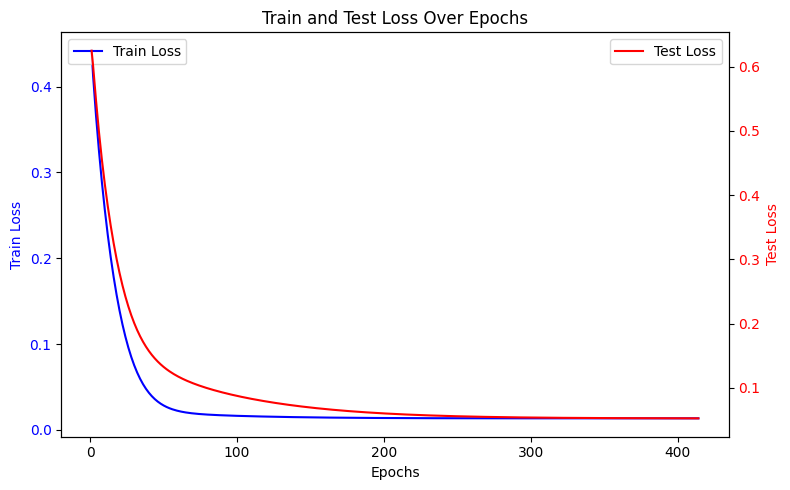

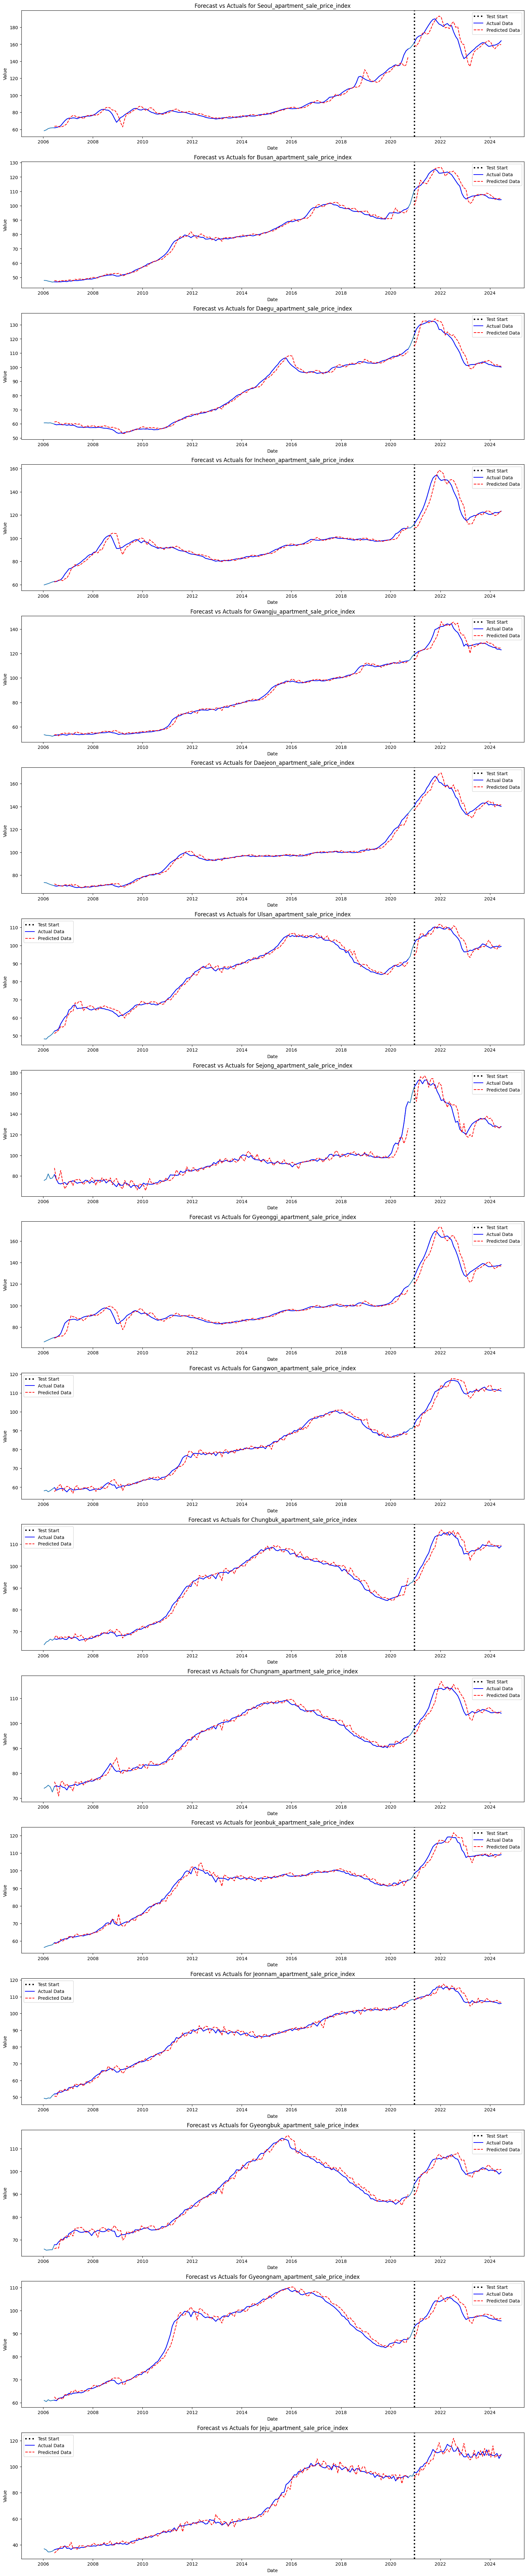

In [347]:
for epoch in tqdm(range(1, epoch_+1)):
    loss_list = []
    DLinear_model.train()
    train_loss = 0.0 
    for batch_idx, (data, target) in enumerate(train_dl):
        
        optimizer.zero_grad()
        output = DLinear_model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        
    train_loss = np.mean(loss_list) 
    train_loss_list.append(train_loss) 

    DLinear_model.eval()
    with torch.no_grad():
        test_loss_list_epoch = []
        for data, target in test_dl:
            output = DLinear_model(data)
            test_loss = criterion(output, target)
            test_loss_list_epoch.append(test_loss.item())
            
        test_loss = np.mean(test_loss_list_epoch)
        test_loss_list.append(test_loss)

    if train_loss < max_loss:
        torch.save(DLinear_model.state_dict(), f"./DLinear{version}.pth")
        max_loss = train_loss
        # print("Train_loss={:.3f}, Test_loss={:.3f}, Model Saved".format(train_loss, test_loss))
        dlinear_best_epoch = epoch
        dlinear_best_train_loss = train_loss
        dlinear_best_test_loss = test_loss
    else:
        patience_counter += 1
        # print("Train_loss={:.3f}, Test_loss={:.3f}, Patience: {}/{}".format(train_loss, test_loss, patience_counter, patience))
    
    if patience_counter >= patience:
        print("Early stopping triggered.")
        break
    
fig, ax1 = plt.subplots(figsize=(8, 5))
epochs = range(1, len(train_loss_list) + 1)
ax1.plot(epochs, train_loss_list, label='Train Loss', color='b')
ax1.set_xlabel('Epochs')
ax1.set_ylabel("Train Loss",color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.legend(loc="upper left")
# ax1.grid()
ax2 = ax1.twinx()
ax2.plot(epochs, test_loss_list, label='Test Loss',color='r')
ax2.set_xlabel('Epochs')
ax2.set_ylabel("Test Loss",color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.legend(loc="upper right") 
# ax2.grid()
plt.title('Train and Test Loss Over Epochs')
fig.tight_layout()
plt.show()
    
# Load model and Evaluate
DLinear_model.load_state_dict(torch.load(f"./DLinear{version}.pth"))  # 최적 모델 로드
DLinear_model.eval()

train_dl  = DataLoader(train_ds,  batch_size = len(train_df), shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size = len(test_df), shuffle=False)
with torch.no_grad():
    for data, target in train_dl:
        train_output = DLinear_model(data)
        train_predicted = train_output[:, -1, :].cpu().numpy()  # Last timestep predictions
        train_actual = target[:, -1, :].cpu().numpy()     # Last timestep actual values
        train_dates = train_date[:, -1]                    # Dates corresponding to the last forecast
    
    for data, target in test_dl:
        test_output = DLinear_model(data)
        test_predicted = test_output[:, -1, :].cpu().numpy()  # Last timestep predictions
        test_actual = target[:, -1, :].cpu().numpy()     # Last timestep actual values
        test_dates = test_date[:, -1]  
    
plt.figure(figsize=(20, len(columns_to_use) * 6))  # Adjust the figure size as needed
for i in range(len(columns_to_use)):
    idv_mean = mean_[columns_to_use[i]]
    idv_std = std_[columns_to_use[i]]
    plt.subplot(len(columns_to_use), 1, i + 1)
    plt.plot(df['Date'], df[columns_to_use[i]])
    plt.plot(train_dates, train_actual[:, i]*idv_std+idv_mean, c="b")
    plt.plot(train_dates, train_predicted[:, i]*idv_std+idv_mean, linestyle='--', c="r")
    plt.axvline(x=test_dates[0], color='black', linestyle=':', linewidth=3,label="Test Start")
    plt.plot(test_dates, test_actual[:, i]*idv_std+idv_mean, label='Actual Data', c="b")
    plt.plot(test_dates, test_predicted[:, i]*idv_std+idv_mean, label='Predicted Data', linestyle='--', c="r")
    plt.title(f'Forecast vs Actuals for {columns_to_use[i]}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()        
    

In [361]:
# Load model and Evaluate
DLinear_model.load_state_dict(torch.load(f"./DLinear{version}.pth"))  # 최적 모델 로드
DLinear_model.eval()

with torch.no_grad():
    for data, target in test_dl:
        test_output = DLinear_model(data)
        test_predicted = test_output[:, -1, :].cpu().numpy()  # Last timestep predictions
        test_actual = target[:, -1, :].cpu().numpy()     # Last timestep actual values
        test_dates = test_date[:, -1]  
    
plt.figure(figsize=(20, len(columns_to_use) * 6))  # Adjust the figure size as needed
for i in range(len(columns_to_use)):
    real = test_actual[:, i]*idv_std+idv_mean
    pred = test_predicted[:, i]*idv_std+idv_mean
    rmse = mean_squared_error(real, pred)**0.5
    r2 = r2_score(real, pred)
    if columns_to_use[i] in nf.columns:
        val = [columns_to_use[i].split("_")[0], rmse, r2]
        pd.DataFrame(val).T.to_csv(f"./result{version}.csv", mode='a', header=False, index=False)
    

<Figure size 2000x10200 with 0 Axes>

### Individual = True

In [362]:
### Experiment Setting
version = "V_idv"
window_size = 3
forecast_size= 3 
epoch_ = 500
lr = 0.001
patience = 20  # early stopping

columns_to_use = nf.columns.tolist()
configs = Namespace( # Convert configs dictionary to Namespace
    seq_len=max(window_size, 1),  # Set minimum input length to 1
    pred_len=forecast_size,
    ker_len=kernel_size,  # 25
    individual=True, 
    enc_in= len(columns_to_use) # feature_size
)

In [ ]:
# Prepare Dataset
# 정규화된 train_df, test_df와 각 칼럼에 대한 mean_, std_ 딕셔너리가 출력됨. 
train_df_fe, test_df_fe, mean_, std_ = standardization(train_df, test_df, date, columns_to_use)
    
train_x, train_y, train_date = time_slide_df(train_df_fe, window_size, forecast_size, date, columns_to_use)
test_x, test_y, test_date = time_slide_df(test_df_fe, window_size, forecast_size, date, columns_to_use)
    
# Prepare DataLoader 
train_ds = Data(train_x, train_y)
test_ds = Data(test_x, test_y)
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size = len(test_df), shuffle=False)

# Train the model 
train_loss_list = [] # save the train loss
test_loss_list = [] # save the test loss

# Define the model
DLinear_model = DLinear(configs=configs)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(DLinear_model.parameters(), lr=lr)
max_loss = 999999999

patience_counter = 0

100%|██████████| 500/500 [01:52<00:00,  4.45it/s]


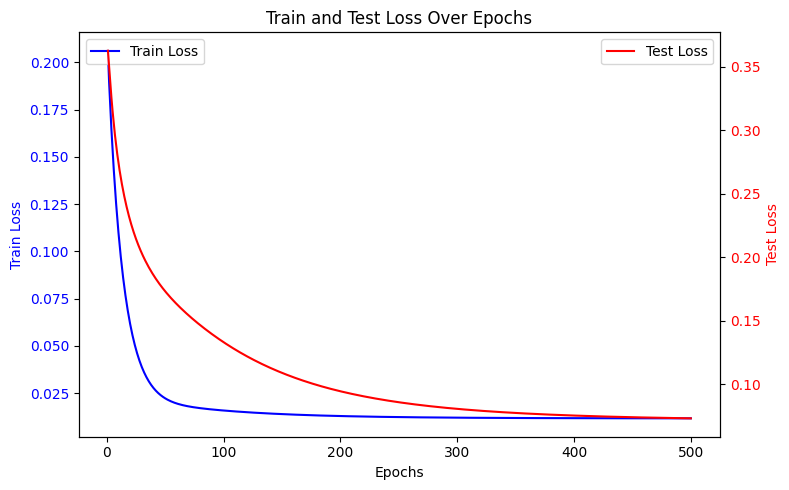

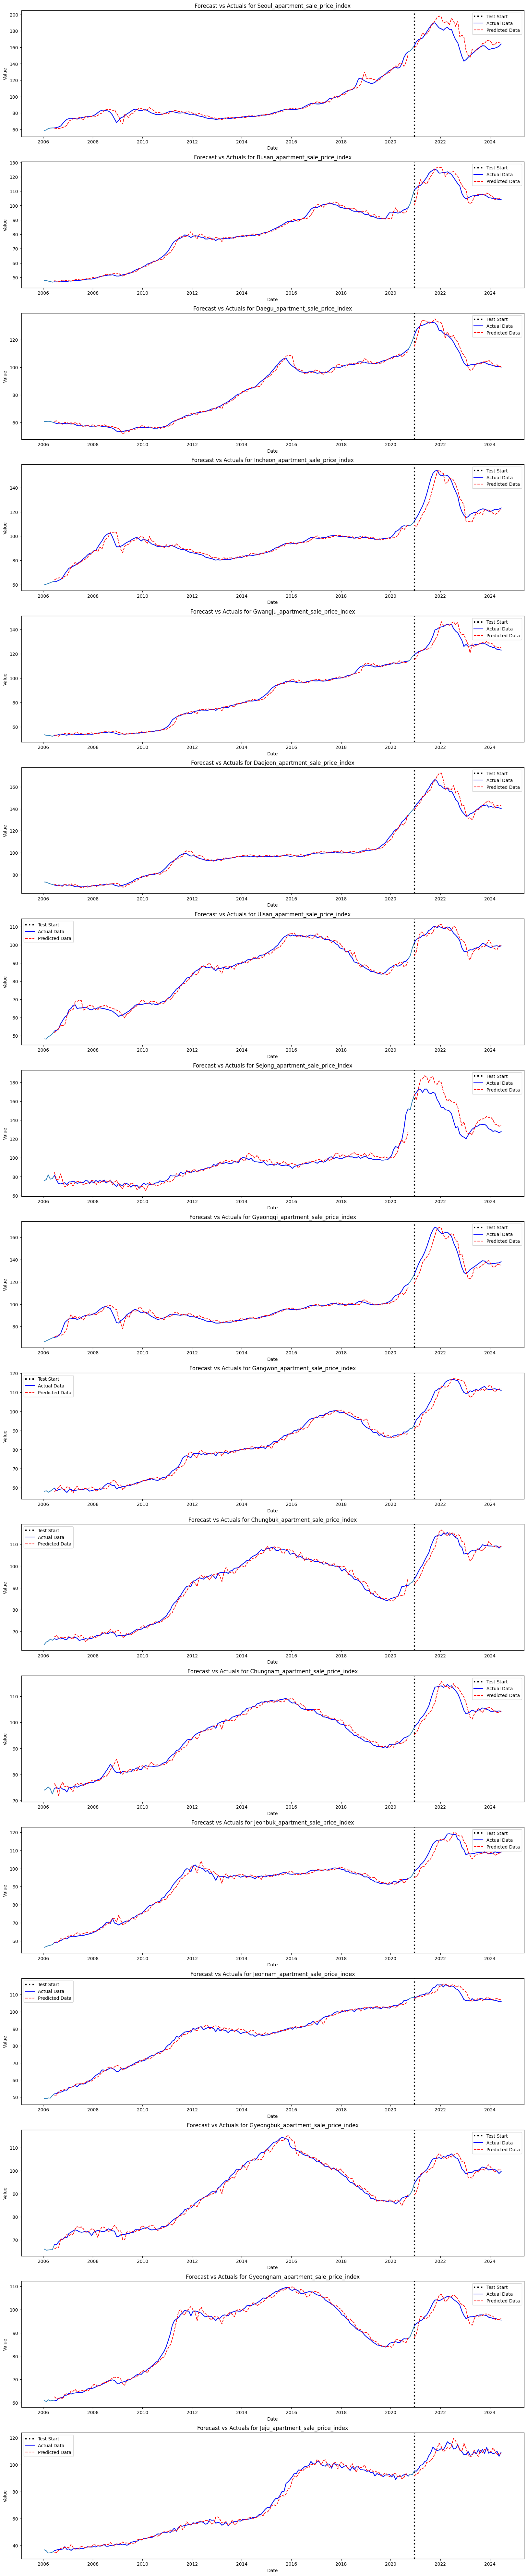

In [363]:
for epoch in tqdm(range(1, epoch_+1)):
    loss_list = []
    DLinear_model.train()
    train_loss = 0.0 
    for batch_idx, (data, target) in enumerate(train_dl):
        
        optimizer.zero_grad()
        output = DLinear_model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        
    train_loss = np.mean(loss_list) 
    train_loss_list.append(train_loss) 

    DLinear_model.eval()
    with torch.no_grad():
        test_loss_list_epoch = []
        for data, target in test_dl:
            output = DLinear_model(data)
            test_loss = criterion(output, target)
            test_loss_list_epoch.append(test_loss.item())
            
        test_loss = np.mean(test_loss_list_epoch)
        test_loss_list.append(test_loss)

    if train_loss < max_loss:
        torch.save(DLinear_model.state_dict(), f"./DLinear{version}.pth")
        max_loss = train_loss
        # print("Train_loss={:.3f}, Test_loss={:.3f}, Model Saved".format(train_loss, test_loss))
        dlinear_best_epoch = epoch
        dlinear_best_train_loss = train_loss
        dlinear_best_test_loss = test_loss
    else:
        patience_counter += 1
        # print("Train_loss={:.3f}, Test_loss={:.3f}, Patience: {}/{}".format(train_loss, test_loss, patience_counter, patience))
    
    if patience_counter >= patience:
        print("Early stopping triggered.")
        break
    
fig, ax1 = plt.subplots(figsize=(8, 5))
epochs = range(1, len(train_loss_list) + 1)
ax1.plot(epochs, train_loss_list, label='Train Loss', color='b')
ax1.set_xlabel('Epochs')
ax1.set_ylabel("Train Loss",color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.legend(loc="upper left")
# ax1.grid()
ax2 = ax1.twinx()
ax2.plot(epochs, test_loss_list, label='Test Loss',color='r')
ax2.set_xlabel('Epochs')
ax2.set_ylabel("Test Loss",color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.legend(loc="upper right") 
# ax2.grid()
plt.title('Train and Test Loss Over Epochs')
fig.tight_layout()
plt.show()
    
# Load model and Evaluate
DLinear_model.load_state_dict(torch.load(f"./DLinear{version}.pth"))  # 최적 모델 로드
DLinear_model.eval()

train_dl  = DataLoader(train_ds,  batch_size = len(train_df), shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size = len(test_df), shuffle=False)
with torch.no_grad():
    for data, target in train_dl:
        train_output = DLinear_model(data)
        train_predicted = train_output[:, -1, :].cpu().numpy()  # Last timestep predictions
        train_actual = target[:, -1, :].cpu().numpy()     # Last timestep actual values
        train_dates = train_date[:, -1]                    # Dates corresponding to the last forecast
    
    for data, target in test_dl:
        test_output = DLinear_model(data)
        test_predicted = test_output[:, -1, :].cpu().numpy()  # Last timestep predictions
        test_actual = target[:, -1, :].cpu().numpy()     # Last timestep actual values
        test_dates = test_date[:, -1]  
    
plt.figure(figsize=(20, len(columns_to_use) * 6))  # Adjust the figure size as needed
for i in range(len(columns_to_use)):
    idv_mean = mean_[columns_to_use[i]]
    idv_std = std_[columns_to_use[i]]
    plt.subplot(len(columns_to_use), 1, i + 1)
    plt.plot(df['Date'], df[columns_to_use[i]])
    plt.plot(train_dates, train_actual[:, i]*idv_std+idv_mean, c="b")
    plt.plot(train_dates, train_predicted[:, i]*idv_std+idv_mean, linestyle='--', c="r")
    plt.axvline(x=test_dates[0], color='black', linestyle=':', linewidth=3,label="Test Start")
    plt.plot(test_dates, test_actual[:, i]*idv_std+idv_mean, label='Actual Data', c="b")
    plt.plot(test_dates, test_predicted[:, i]*idv_std+idv_mean, label='Predicted Data', linestyle='--', c="r")
    plt.title(f'Forecast vs Actuals for {columns_to_use[i]}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()        
    

In [364]:
# Load model and Evaluate
DLinear_model.load_state_dict(torch.load(f"./DLinear{version}.pth"))  # 최적 모델 로드
DLinear_model.eval()

with torch.no_grad():
    for data, target in test_dl:
        test_output = DLinear_model(data)
        test_predicted = test_output[:, -1, :].cpu().numpy()  # Last timestep predictions
        test_actual = target[:, -1, :].cpu().numpy()     # Last timestep actual values
        test_dates = test_date[:, -1]  
    
plt.figure(figsize=(20, len(columns_to_use) * 6))  # Adjust the figure size as needed
for i in range(len(columns_to_use)):
    real = test_actual[:, i]*idv_std+idv_mean
    pred = test_predicted[:, i]*idv_std+idv_mean
    rmse = mean_squared_error(real, pred)**0.5
    r2 = r2_score(real, pred)
    if columns_to_use[i] in nf.columns:
        val = [columns_to_use[i].split("_")[0], rmse, r2]
        pd.DataFrame(val).T.to_csv(f"./result{version}.csv", mode='a', header=False, index=False)
    

<Figure size 2000x10200 with 0 Axes>